In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, collections
from scipy import signal, fftpack, fft
from itertools import izip

In [2]:
df = pd.read_csv('C:\Users\John\Documents\GitHub\dissertation\ROP_alldata.csv', index_col=0)
df.index = pd.to_datetime(df.index)
#Phases:
# PRE, ED1, ED2, ED3, DURING, AFTER
df1 = df.loc[df['ID'] == 13]
df2 = df.loc[df['ID'] == 31]

In [3]:
window = 31
polyorder = 6
fs = 0.5 #Sample Rate in Hz

def SG(data):

    y = signal.savgol_filter(data, window, polyorder)
    df_result = pd.DataFrame({'SG_StO2' : y}, index = np.arange(0, len(y)*2, 2))
    df_result = df_result.dropna()
    
    return df_result

In [4]:
def PSD(y, fs, neonate, time): #y = dataset, fs = sampling frequency in Hz
    #get the whole Power Spectral Density

    f, Pxx_den = signal.periodogram(y, fs)
    Pxx_den = 10*np.log10(Pxx_den) #Conversion into decibel scale
    plt.semilogy(f[1:], Pxx_den[1:], color='k') #remove frequency = 0 Hz
    plt.yscale('linear') #Change y axis scaling
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title('StO2 Power Spectral Density ' + time)
    plt.savefig('C:\Users\John\Documents\GitHub\dissertation\plots\\' + neonate + '_PSD_' + time + '.png', dpi=300)
    plt.show()
    
    return max(f[1:]), max(Pxx_den[1:])

def PSD_LF(y, fs, neonate, time, xlim_max = 0.03):
    #plot the low frequency spectral density
               
    f, Pxx_den = signal.periodogram(y, fs)
    Pxx_den = 10*np.log10(Pxx_den) #Conversion into decibel scale
    plt.semilogy(f[1:], Pxx_den[1:], color='k') #remove frequency = 0 Hz
    plt.yscale('linear') #Change y axis scaling
    plt.ylim([0, 60]) #set limits for visibility
    plt.xlim([0, xlim_max]) #xlimit can be changed
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title('StO2 Power Spectral Density at Low Frequency ' + time)
    plt.savefig('C:\Users\John\Documents\GitHub\dissertation\plots\\' + neonate + '_PSD_LF_' + time + '.png', dpi=300)
    plt.show()
    
    return

In [5]:
def poincare(array):
    #Function to calculate poincare plot values
    #Definitions obtained from http://www.if.uz.zgora.pl/~jaropis/geomasy.pdf
    #Modified from BASS code that was written by Abigail Dobyns 
    #See https://github.com/drcgw/bass
    
    df = pd.DataFrame(array)
    data = df.dropna()
    data = data[0].values
    
    x = data[:-1]
    y = data[1:]
    
    xc = np.mean(x)
    yc = np.mean(y)  
    
    SD1 = 0
    SD2 = 0
    
    for i in np.arange(len(x)):
        
        d1 = np.power(abs((x[i]-xc)-(y[i]-yc))/np.sqrt(2), 2)
        SD1 = SD1 + d1
        
        d2 = np.power(abs((x[i]-xc)+(y[i]-yc))/np.sqrt(2), 2)
        SD2 = SD2 + d2
    
    SD1 = np.sqrt(SD1/len(x))
    SD2 = np.sqrt(SD2/len(x))
    
    return x, y, xc, yc, SD1, SD2

def poincare_plot(data, neonate, time):
    #function to plot
    x, y, xc, yc, SD1, SD2 = poincare(data)
    
    center = xc, yc
    
    ax = plt.subplot(111, aspect = "equal")
    
    plt.plot(center[0], center[1], color="r", marker= "+")

    y1 = x
    y2 = y
    
    #width and height are diameter
    ellipse = patches.Ellipse(center, width = SD2, height = SD1, angle = 45, fill = False, color = "r") 

    ax.set_xlabel("StO2 (t)")
    ax.set_ylabel("StO2 (t+1)")
    ax.scatter(y1, y2, color = 'k', marker = '.')
    ax.add_patch(ellipse)
    
    #line segments of ellipses axes
    lines = [[(xc-SD1/2, yc+SD1/2), (xc+SD1/2, yc-SD1/2)], [(xc-SD2/2, yc-SD2/2), (xc+SD2/2, yc+SD2/2)]]
    lc = collections.LineCollection(lines, colors='r')
    ax.add_collection(lc)

    plt.title('StO2 Poincare Plot ' + time)
    
    plt.savefig('C:\Users\John\Documents\GitHub\dissertation\plots\\' + neonate + '_Poincare_Plot_' + time + '.png', dpi=300)
    
    plt.show()
    
    return SD1, SD2

In [6]:
def initialize_df(df):
    
    if df['ID'][0] == 13:
        neonate = '1'
    elif df['ID'][0] == 31:
        neonate = '2'
    else:
        raise NameError('Not valid ID') #account for more babies
        
    #split into time epochs
    df_a = df['StO2'].loc[df['Phase'] == 'PRE'].iloc[-1800:].dropna() #before eyedrops
    df_b = df['StO2'].loc[df['Phase'] == 'ED1'].dropna() #1st deyedrop
    df_c = df['StO2'].loc[df['Phase'] == 'ED2'].dropna() #2nd eye drops
    df_d = df['StO2'].loc[df['Phase'] == 'ED3'].dropna() #3rd eye drops
    df_e = df['StO2'].loc[df['Phase'] == 'DURING'].dropna() #during
    df_f = df['StO2'].loc[df['Phase'] == 'AFTER'].iloc[0:1800].dropna() #Hour 1
    df_g = df['StO2'].loc[df['Phase'] == 'AFTER'].iloc[0+(1800*1):1800+(1800*1)].dropna() #Hour 2
    df_h = df['StO2'].loc[df['Phase'] == 'AFTER'].iloc[0+(1800*2):1800+(1800*2)].dropna() #Hour 3
    df_i = df['StO2'].loc[df['Phase'] == 'AFTER'].iloc[0+(1800*3):1800+(1800*3)].dropna() #Hour 4
    df_j = df['StO2'].loc[df['Phase'] == 'AFTER'].iloc[0+(1800*4):1800+(1800*4)].dropna() #Hour 5
    df_k = df['StO2'].loc[df['Phase'] == 'AFTER'].iloc[0+(1800*5):1800+(1800*5)].dropna() #Hour 6
    df_l = df['StO2'].loc[df['Phase'] == 'AFTER'].iloc[0+(1800*6):1800+(1800*6)].dropna() #Hour 7
    df_m = df['StO2'].loc[df['Phase'] == 'AFTER'].iloc[0+(1800*7):1800+(1800*7)].dropna() #Hour 8
    df_n = df['StO2'].loc[df['Phase'] == 'AFTER'].iloc[0+(1800*8):1800+(1800*8)].dropna() #Hour 9
    df_o = df['StO2'].loc[df['Phase'] == 'AFTER'].iloc[0+(1800*9):1800+(1800*9)].dropna() #Hour 10
    df_p = df['StO2'].loc[df['Phase'] == 'AFTER'].iloc[0+(1800*10):1800+(1800*10)].dropna() #Hour 11
    df_q = df['StO2'].loc[df['Phase'] == 'AFTER'].iloc[0+(1800*11):1800+(1800*11)].dropna() #Hour 12

    dflst = [df_a, df_b, df_c, df_d, df_e, df_f, df_g, df_h, df_i, df_j, df_k, df_l, df_m, df_n, df_o, df_p, df_q]
    timelst = ['PRE', 'ED1', 'ED2', 'ED3', 'DUR', '1H', '2H', '3H', '4H', '5H', '6H', '7H', '8H', '9H', '10H', '11H', '12H']
    df_final = pd.DataFrame(columns=['Freq', 'Max dB', 'SD1', 'SD2', 'SD1/SD2']) #freq at max dB
    
    #initialize new list
    dflst_filt = []
    
    #apply SG_Filter
    for i, time in izip(dflst, timelst):
        #i = i.dropna()
        i_filt = SG(i)
        dflst_filt.append(i_filt['SG_StO2'].values)
        i_filt.plot(legend=None, color='k')
        plt.title('StO2 Filtered ' + time)
        plt.ylabel('StO2')
        plt.xlabel('Time (s)')
        plt.savefig('C:\Users\John\Documents\GitHub\dissertation\plots\\' + neonate + '_Filtered_StO2_' + time + '.png', dpi=300)
    
    
    #initialize lists
    max_dB = []
    freq_at_max_dB = []
    SD1_lst = []
    SD2_lst = []

    for i, time in izip(dflst_filt, timelst):
        
        #Apply PSD
        print time
        freq, dB = PSD(i, fs, neonate, time)
        max_dB.append(dB)
        freq_at_max_dB.append(freq)
        
        PSD_LF(i, fs, neonate, time)
        
    #Apply Poincare
    
        SD1, SD2 = poincare_plot(i, neonate, time)
        SD1_lst.append(SD1)
        SD2_lst.append(SD2)
    
    df_final['Max dB'] = max_dB 
    df_final['Freq'] = freq_at_max_dB    
    
    df_final['SD1'] = SD1_lst
    df_final['SD2'] = SD2_lst
    df_final['SD1/SD2'] = df_final['SD1']/df_final['SD2']
                            
    return df_final

PRE


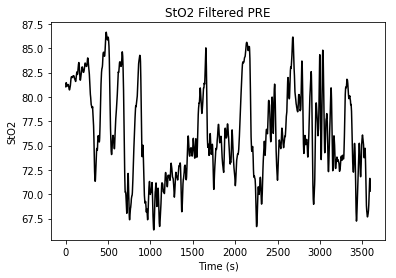

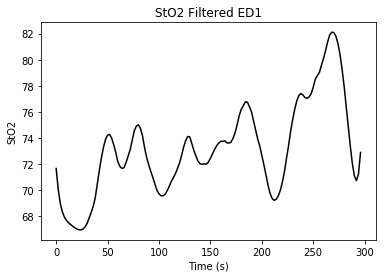

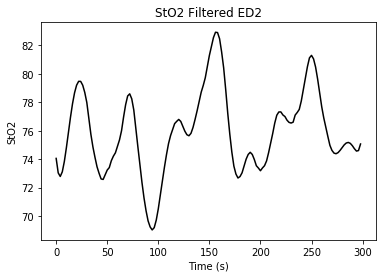

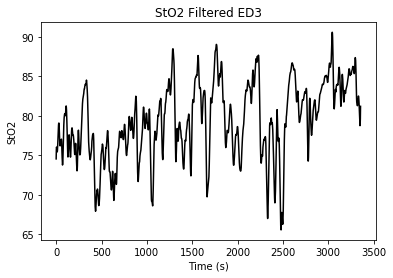

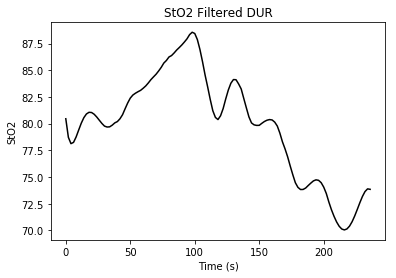

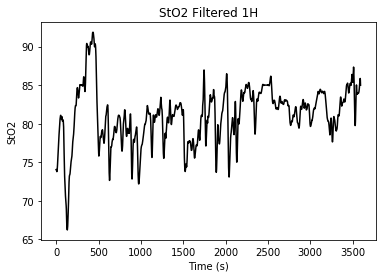

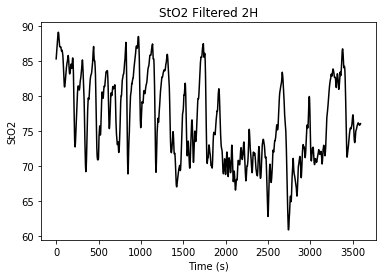

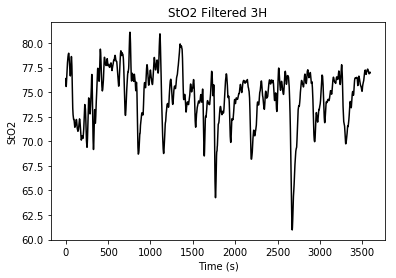

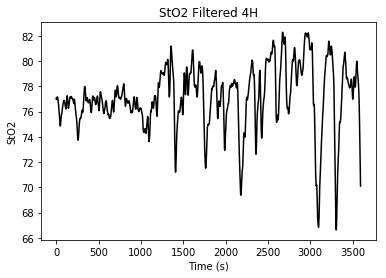

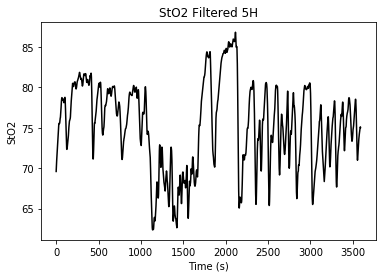

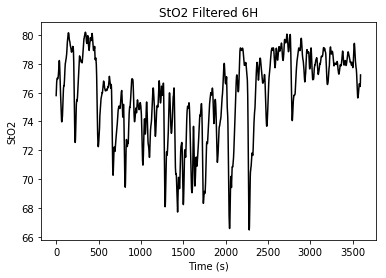

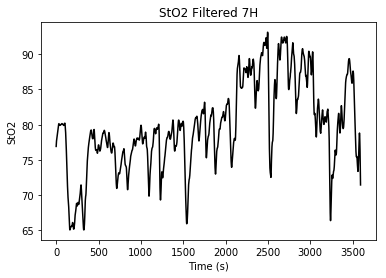

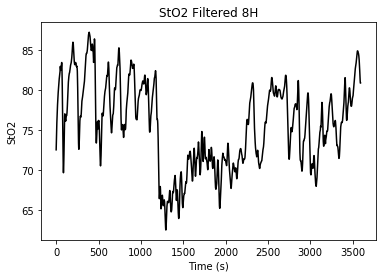

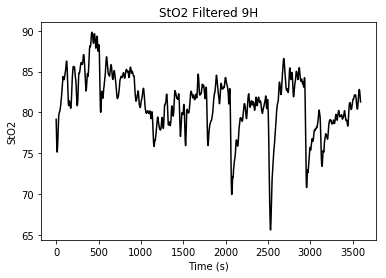

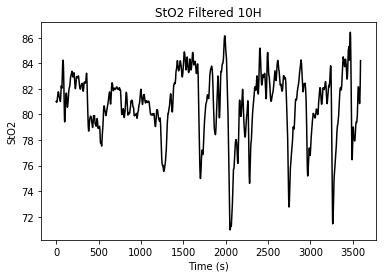

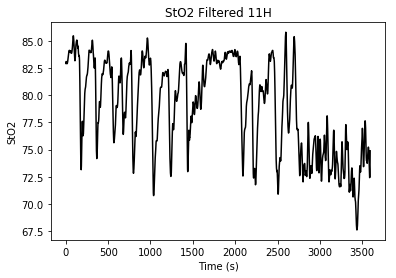

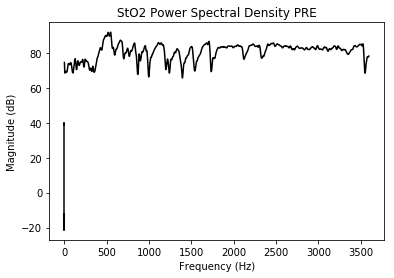

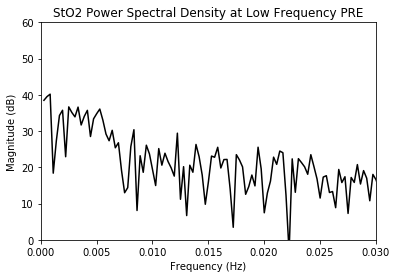

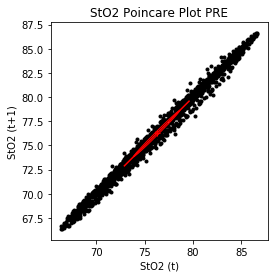

ED1


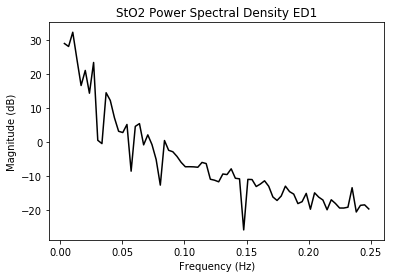

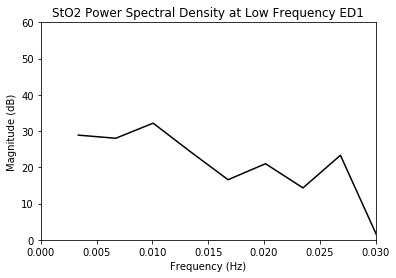

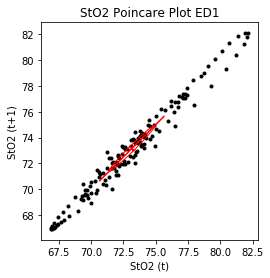

ED2


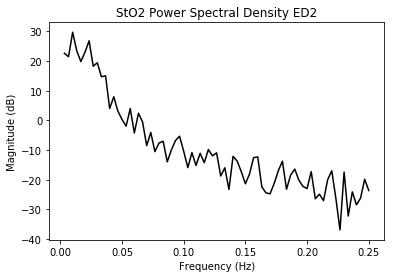

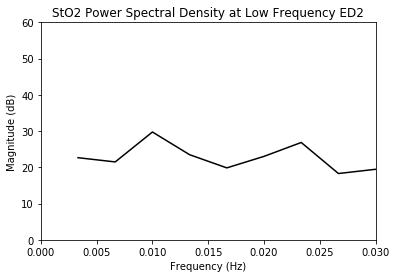

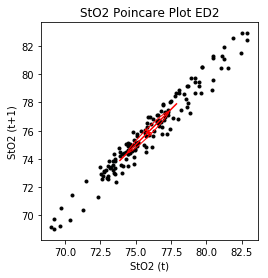

ED3


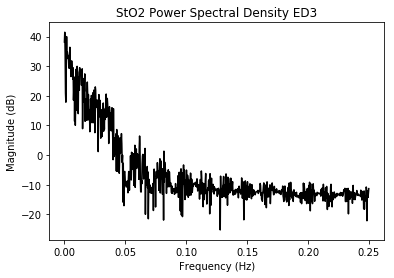

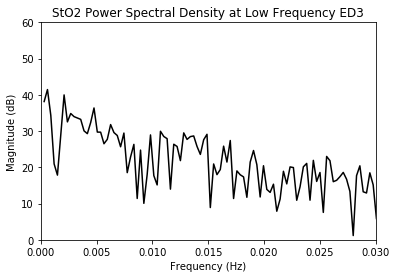

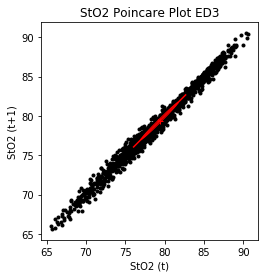

DUR


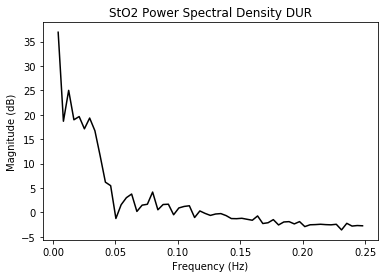

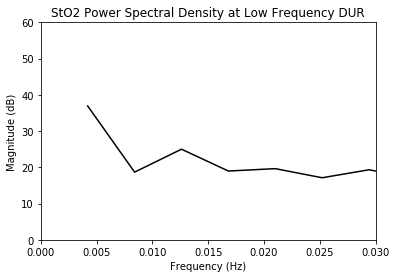

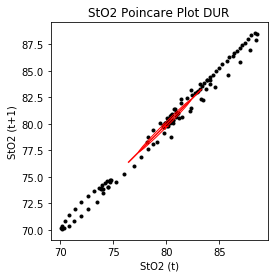

1H


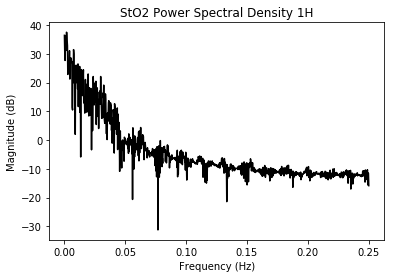

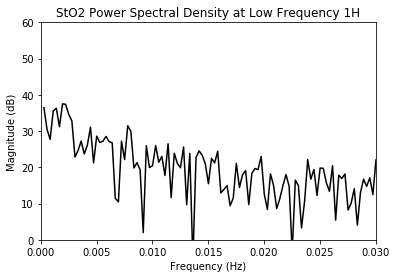

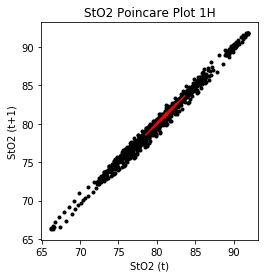

2H


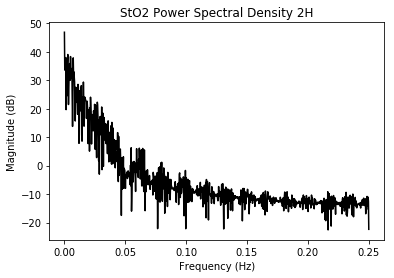

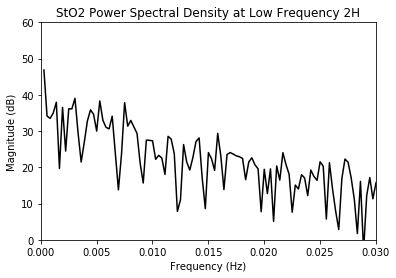

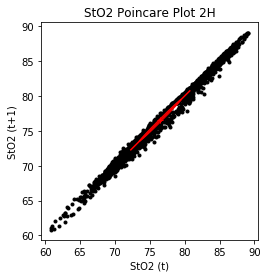

3H


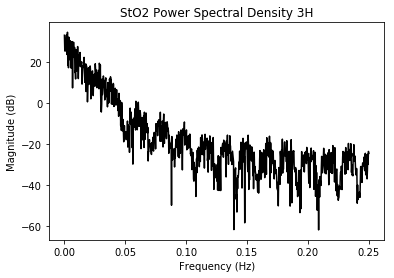

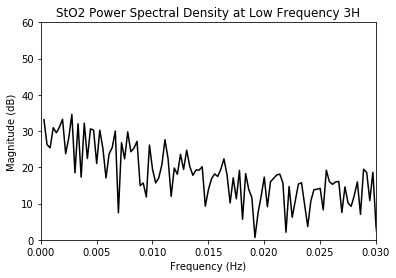

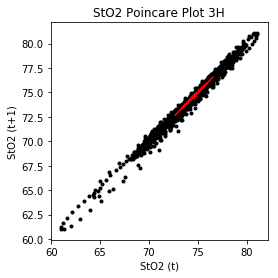

4H


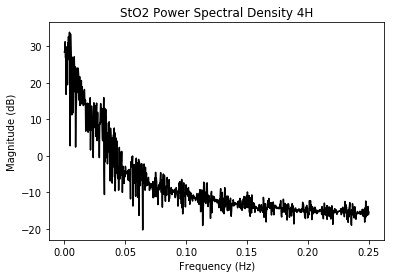

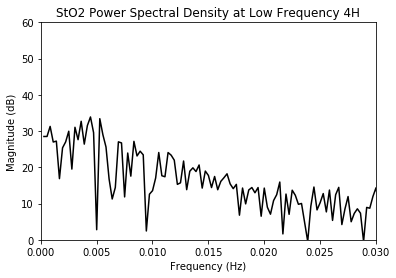

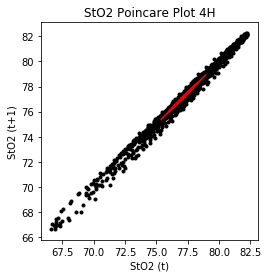

5H


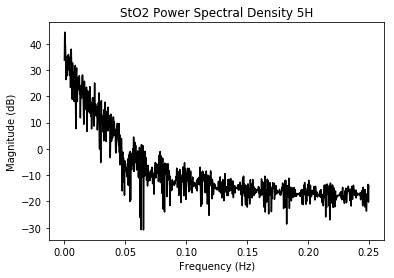

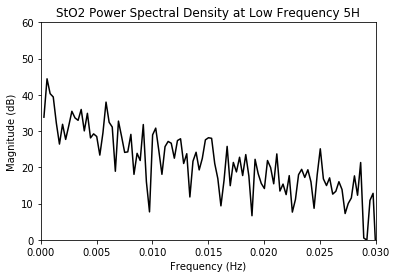

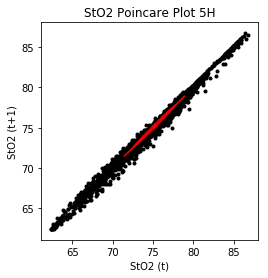

6H


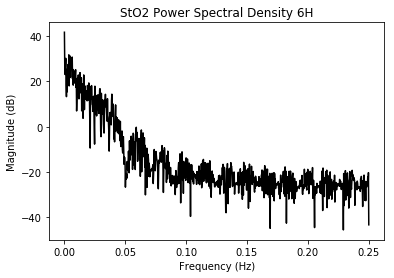

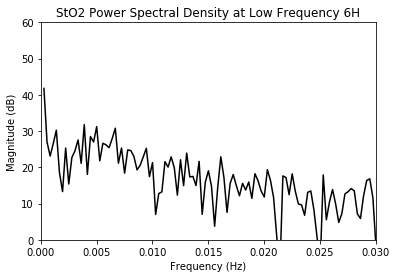

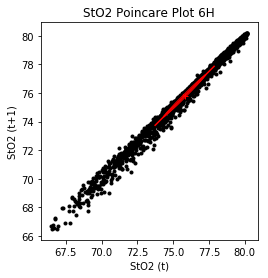

7H


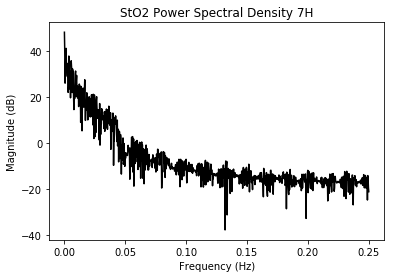

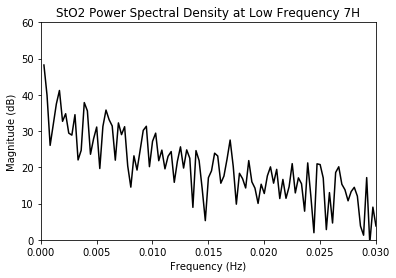

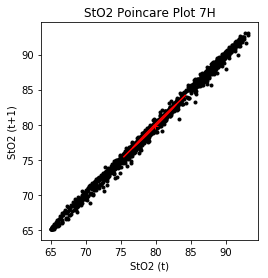

8H


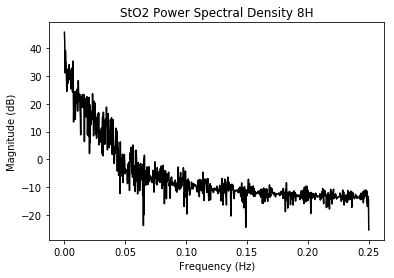

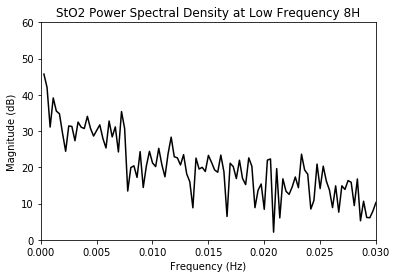

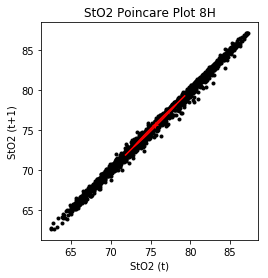

9H


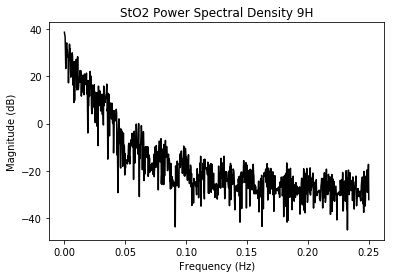

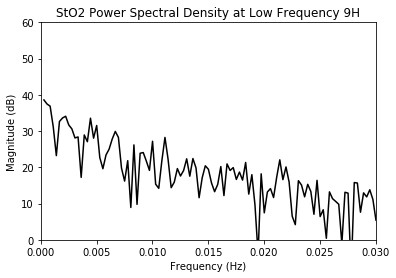

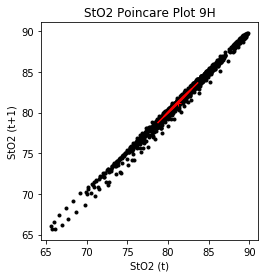

10H


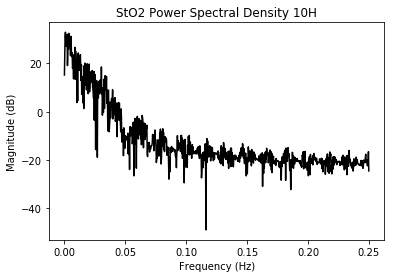

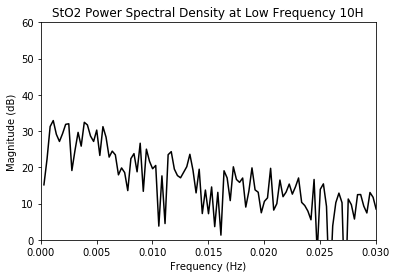

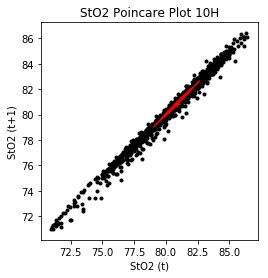

11H


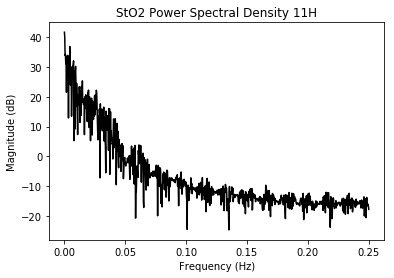

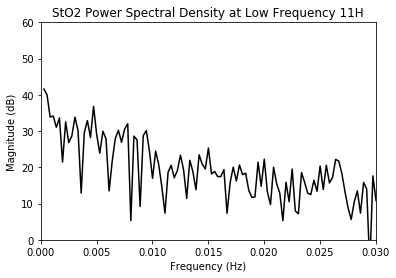

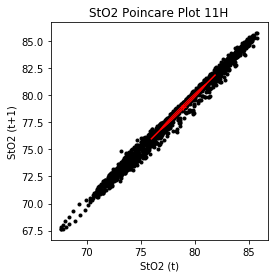

12H


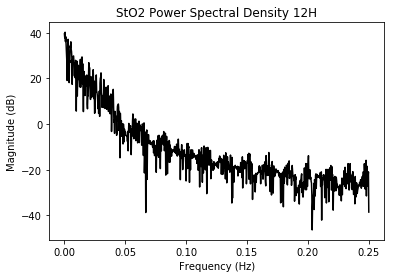

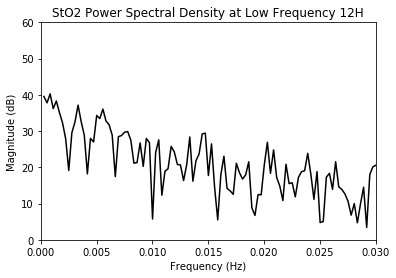

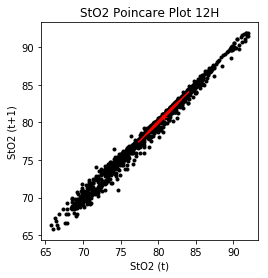

PRE


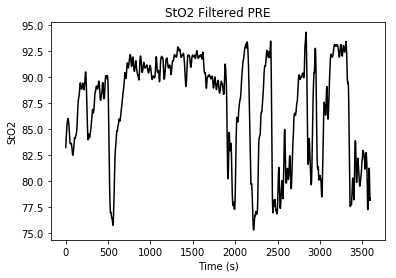

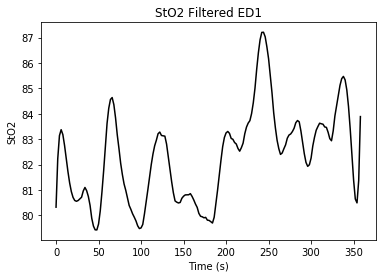

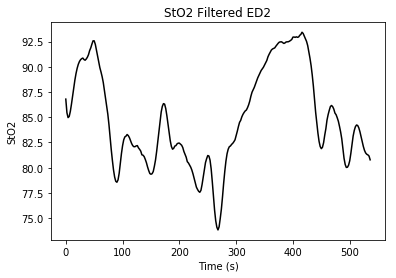

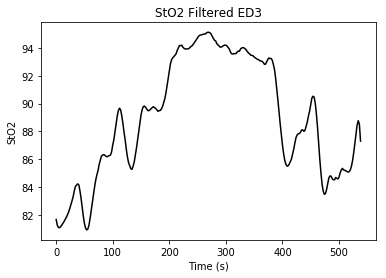

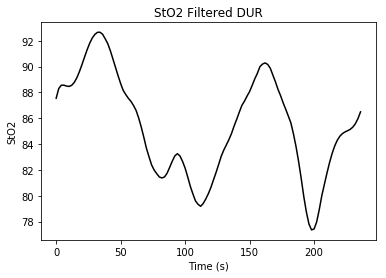

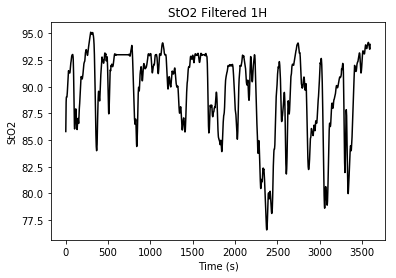

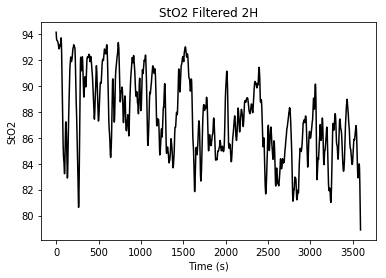

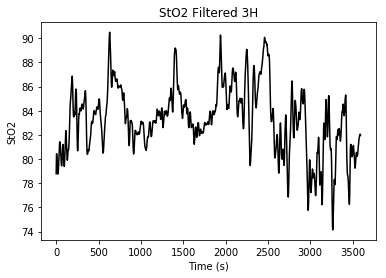

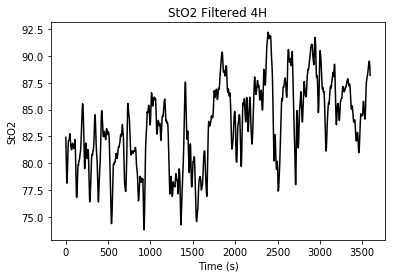

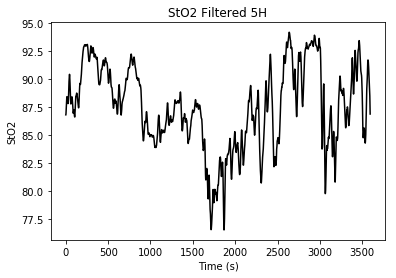

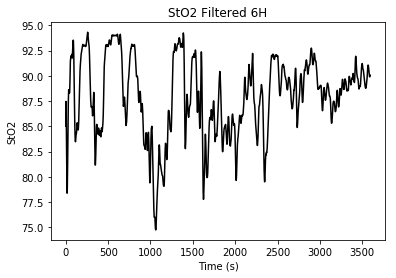

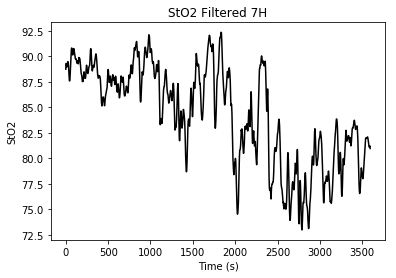

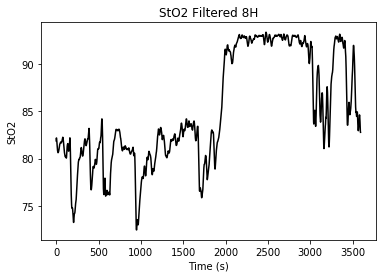

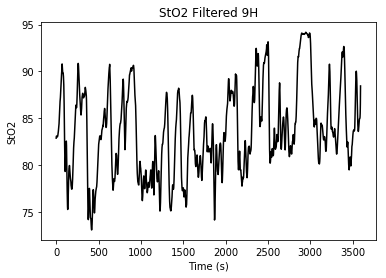

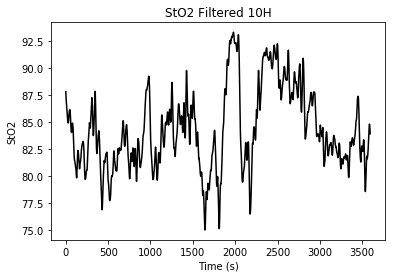

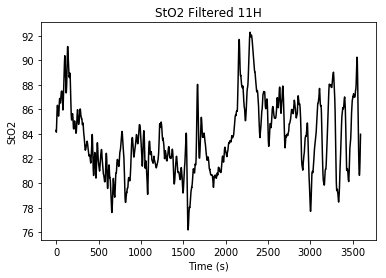

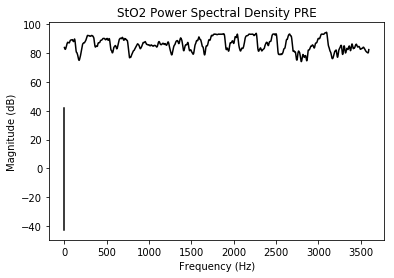

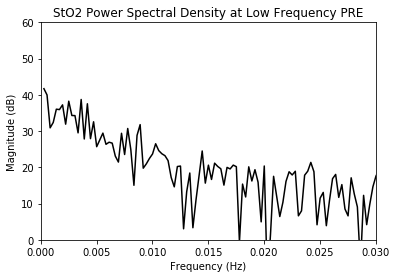

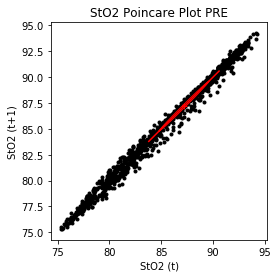

ED1


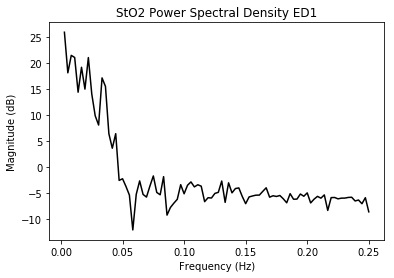

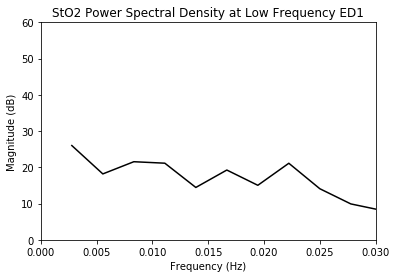

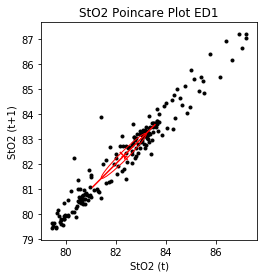

ED2


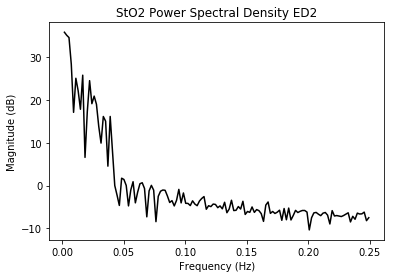

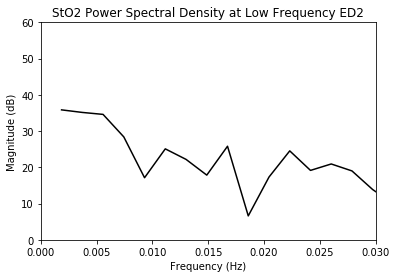

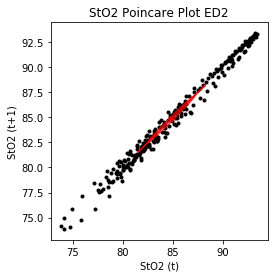

ED3


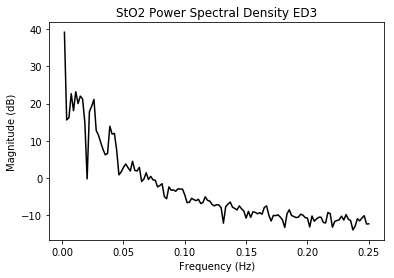

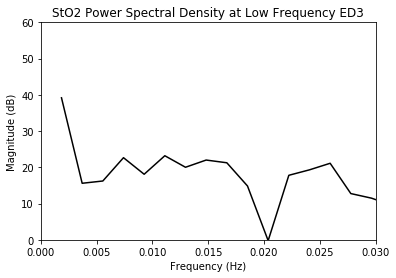

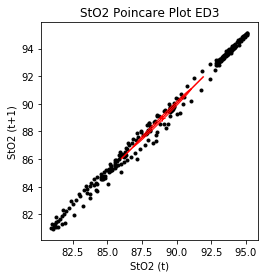

DUR


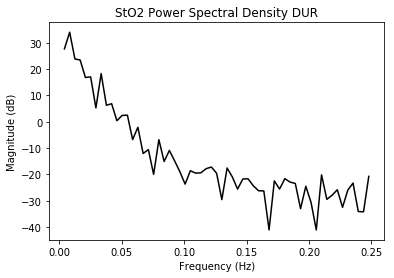

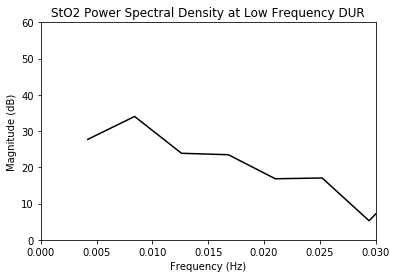

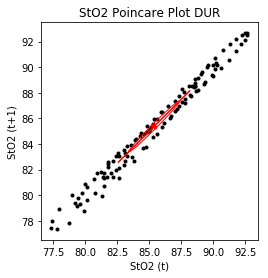

1H


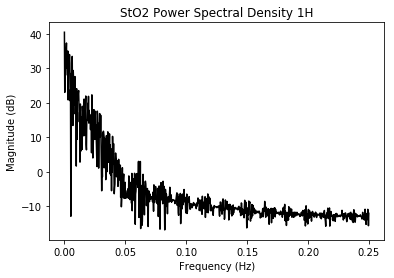

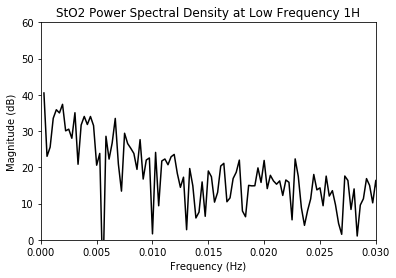

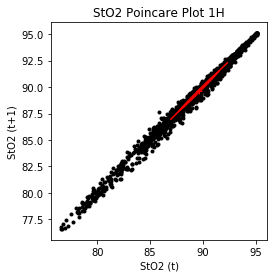

2H


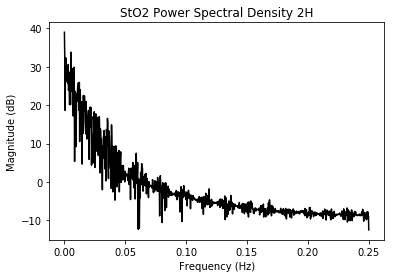

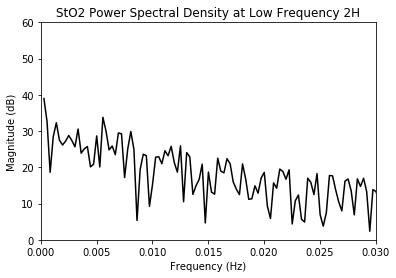

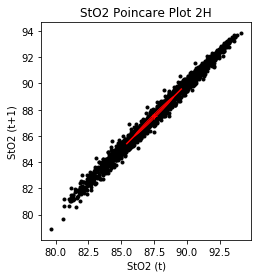

3H


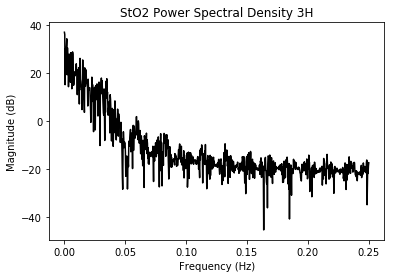

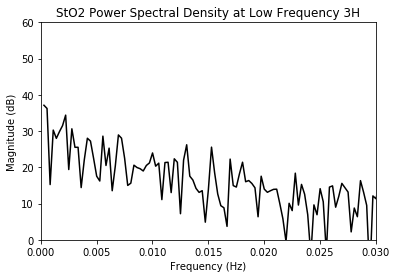

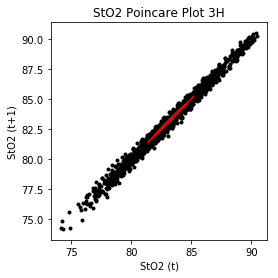

4H


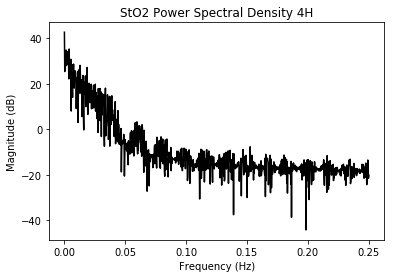

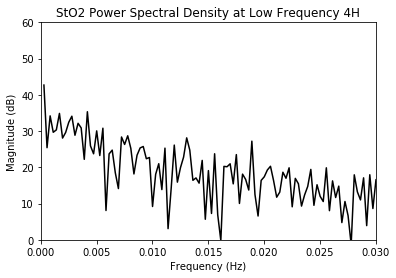

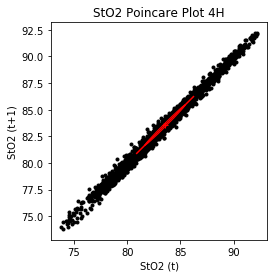

5H


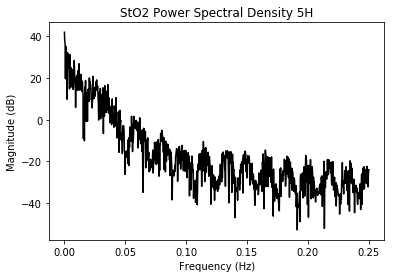

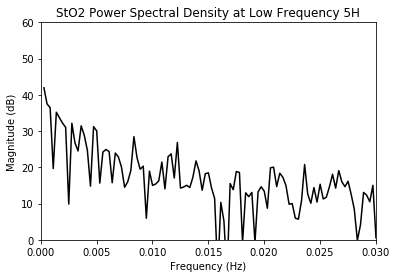

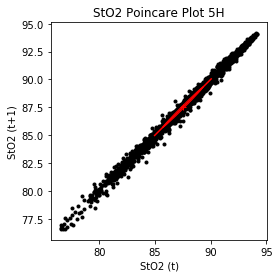

6H


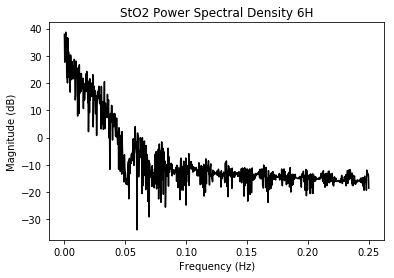

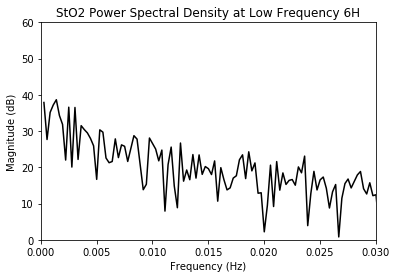

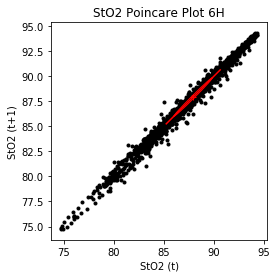

7H


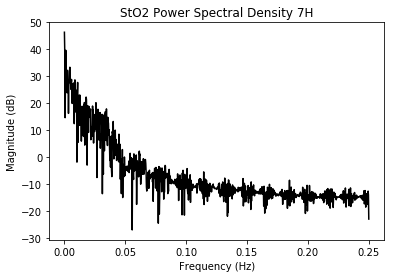

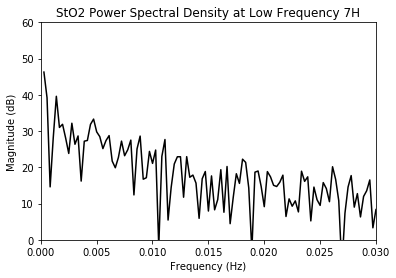

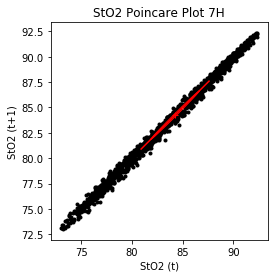

8H


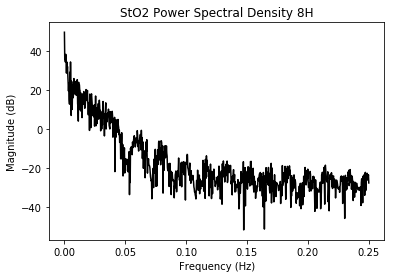

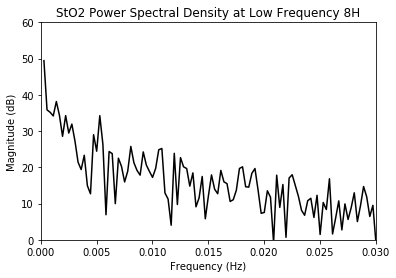

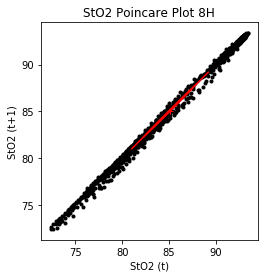

9H


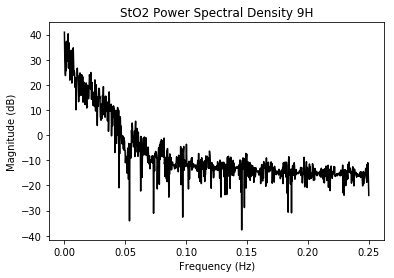

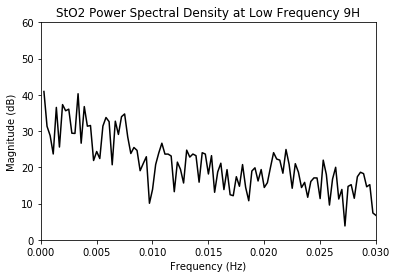

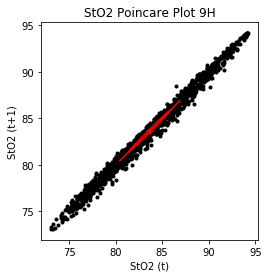

10H


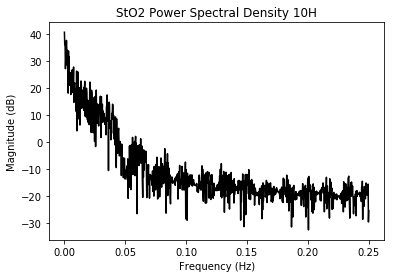

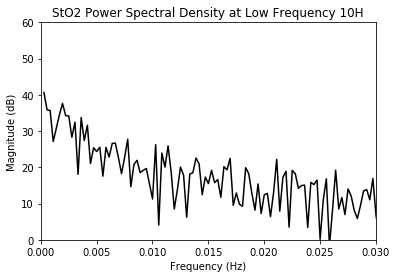

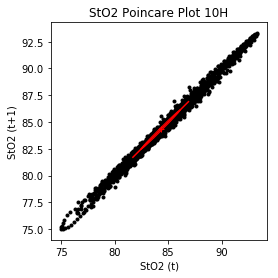

11H


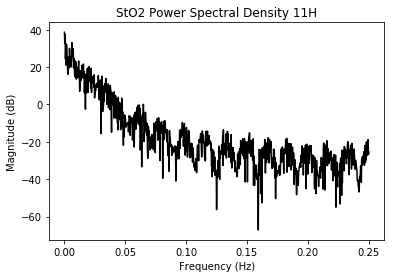

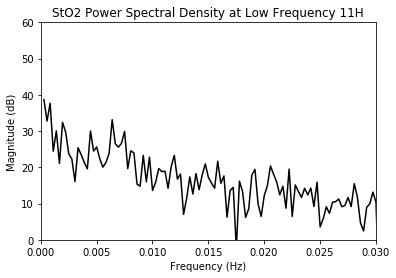

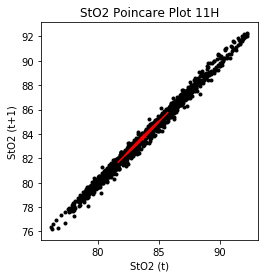

12H


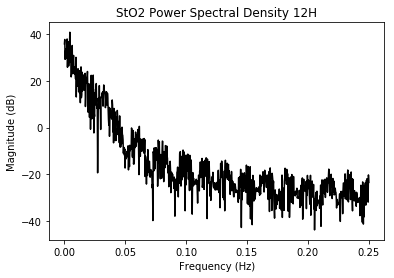

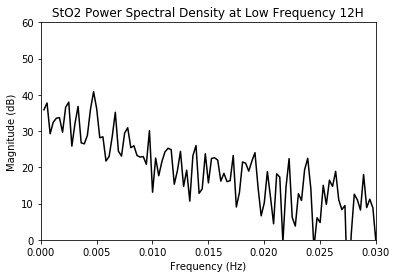

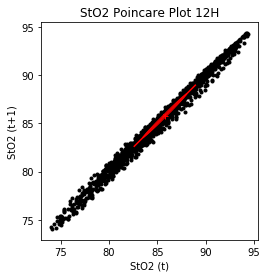

Wall time: 29.3 s


In [7]:
%%time

dff1 = initialize_df(df1)
dff2 = initialize_df(df2)

In [8]:
#Zip up the dataframes according to neonate
def zip_dataframes(var):
    dff = pd.DataFrame(columns=['Neonate 1', 'Neonate 2'])
    dff['Neonate 1'] = dff1[var]
    dff['Neonate 2'] = dff2[var]
    dff.index = ['PRE', 'ED1', 'ED2', 'ED3', 'DUR', '1H', '2H', '3H', '4H', '5H', '6H', '7H', '8H', '9H', '10H', '11H', '12H']
    
    dff.plot.line(marker = 'o')
    plt.xticks(np.arange(17), dff.index, rotation=45)
    plt.legend(loc='upper right')
    plt.title(var)
    
    if 'Freq' in var:
        plt.ylabel('Hz')   
        plt.title('Frequency at max dB')
    elif 'dB' in var:
        plt.ylabel('dB') 
        plt.title('max dB')
    elif '/' in var:
        plt.ylabel('ratio')
        plt.title('SD1/SD2 Ratio')
    elif 'SD1' in var:
        plt.ylabel('SD1')
        plt.title('SD1')
    elif 'SD2' in var:
        plt.ylabel('SD2')
        plt.title('SD2')
        
    
    
    if var == 'SD1/SD2':
        label = 'SD1SD2ratio'
    else:
        label = var
    
    plt.savefig('C:\Users\John\Documents\GitHub\dissertation\plots\\' + label + '.png', dpi=300)
    plt.show()
    
    print dff
    return 

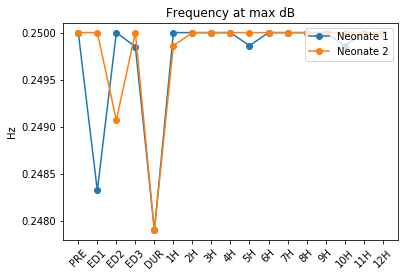

     Neonate 1  Neonate 2
PRE   0.250000   0.250000
ED1   0.248322   0.250000
ED2   0.250000   0.249071
ED3   0.249851   0.250000
DUR   0.247899   0.247899
1H    0.250000   0.249861
2H    0.250000   0.250000
3H    0.250000   0.250000
4H    0.250000   0.250000
5H    0.249861   0.250000
6H    0.250000   0.250000
7H    0.250000   0.250000
8H    0.250000   0.250000
9H    0.250000   0.250000
10H   0.249861   0.250000
11H   0.250000   0.250000
12H   0.250000   0.250000


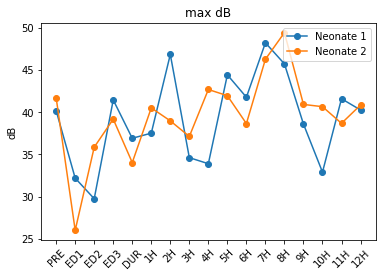

     Neonate 1  Neonate 2
PRE  40.181074  41.699753
ED1  32.186336  26.006292
ED2  29.746770  35.851926
ED3  41.453332  39.181378
DUR  36.912977  34.033238
1H   37.518888  40.512361
2H   46.847559  38.976024
3H   34.614269  37.127674
4H   33.896232  42.693515
5H   44.427985  41.958069
6H   41.776448  38.652751
7H   48.228384  46.277753
8H   45.726647  49.433610
9H   38.593663  40.922772
10H  32.901274  40.656434
11H  41.597451  38.682561
12H  40.262685  40.853864


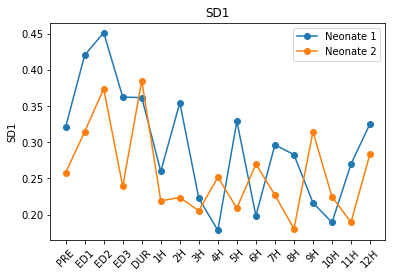

     Neonate 1  Neonate 2
PRE   0.321296   0.257898
ED1   0.420309   0.314682
ED2   0.451529   0.373892
ED3   0.362471   0.238849
DUR   0.361663   0.385006
1H    0.259716   0.219028
2H    0.354585   0.223541
3H    0.222349   0.205336
4H    0.178262   0.251662
5H    0.329097   0.208948
6H    0.198249   0.269618
7H    0.296437   0.226980
8H    0.282812   0.180334
9H    0.216420   0.314497
10H   0.189112   0.224639
11H   0.269763   0.189443
12H   0.325635   0.283996


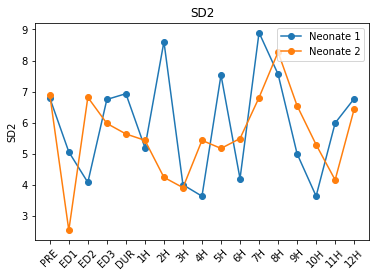

     Neonate 1  Neonate 2
PRE   6.795455   6.900946
ED1   5.059079   2.535646
ED2   4.077222   6.816233
ED3   6.747351   5.975439
DUR   6.933321   5.636962
1H    5.198794   5.432468
2H    8.607192   4.240046
3H    4.002012   3.909321
4H    3.633623   5.430672
5H    7.533661   5.171373
6H    4.197666   5.489082
7H    8.899293   6.807959
8H    7.562157   8.272754
9H    4.999420   6.546178
10H   3.635034   5.291736
11H   5.987574   4.156689
12H   6.773398   6.436399


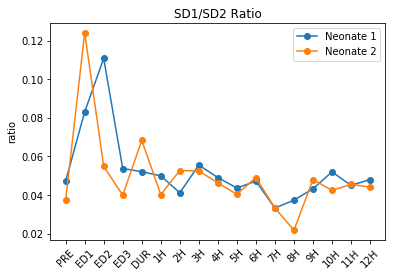

     Neonate 1  Neonate 2
PRE   0.047281   0.037371
ED1   0.083080   0.124103
ED2   0.110744   0.054853
ED3   0.053720   0.039972
DUR   0.052163   0.068300
1H    0.049957   0.040318
2H    0.041196   0.052721
3H    0.055559   0.052525
4H    0.049059   0.046341
5H    0.043684   0.040405
6H    0.047228   0.049119
7H    0.033310   0.033340
8H    0.037398   0.021799
9H    0.043289   0.048043
10H   0.052025   0.042451
11H   0.045054   0.045575
12H   0.048076   0.044123


In [9]:
zip_dataframes('Freq')
zip_dataframes('Max dB')
zip_dataframes('SD1')
zip_dataframes('SD2')
zip_dataframes('SD1/SD2')